In [1]:
%matplotlib inline
# %matplotlib notebook
from sklearn.model_selection import train_test_split
import numpy as np
import qutip as qt
from sklearn.manifold import TSNE
from vae import * 
from scipy.stats import linregress
from qiskit.quantum_info import Statevector, DensityMatrix
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

2023-06-05 21:06:07.317452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 21:06:07.421876: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-05 21:06:07.424387: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-05 21:06:07.424396: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
fig_size_dim    = 4
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "serif",
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': True,
             }

    plt.rcParams.update(params)
plot_style()

In [3]:
n_angle = 101
n_samples = 1000
scan_arr = np.linspace(0, np.pi, n_angle)
alpha_arr = np.zeros(101000)
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1

# Noiseless Dataset

Load Dataset

In [4]:
rho_arr_noiseless = np.load('unitary_4x4_101_1000_noiseless.npy', mmap_mode="r")
X_train_noiseless, X_test_noiseless, y_train_noiseless, y_test_noiseless = train_test_split(rho_arr_noiseless, alpha_arr, random_state=42)
concurrence_noiseless_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test_noiseless])

Define Hyperparameters and load trained VAE:

In [5]:
batch_size = 64
beta = 0.0
learning_rate = 0.0001
lat_dim = 1

encoder, decoder = vae_mlp_4x4(lat_dim, "relu", "tanh")
encoder.load_weights("encoder_noiseless.h5")
decoder.load_weights("decoder_noiseless.h5")

vae_noiseless = VAE(encoder, decoder, beta)
vae_noiseless.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae_noiseless.fit(X_test_noiseless, epochs=1, batch_size=64, verbose=1) 

z_mean_noiseless, z_log_var_noiseless, z_noiseless = vae_noiseless.encoder.predict(X_test_noiseless)

2023-06-05 21:06:26.163615: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-05 21:06:26.163632: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-05 21:06:26.163654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (felix-Latitude-5521): /proc/driver/nvidia/version does not exist
2023-06-05 21:06:26.163933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


790/790 [==============================] - 1s 572us/step


Investigate Latent Space

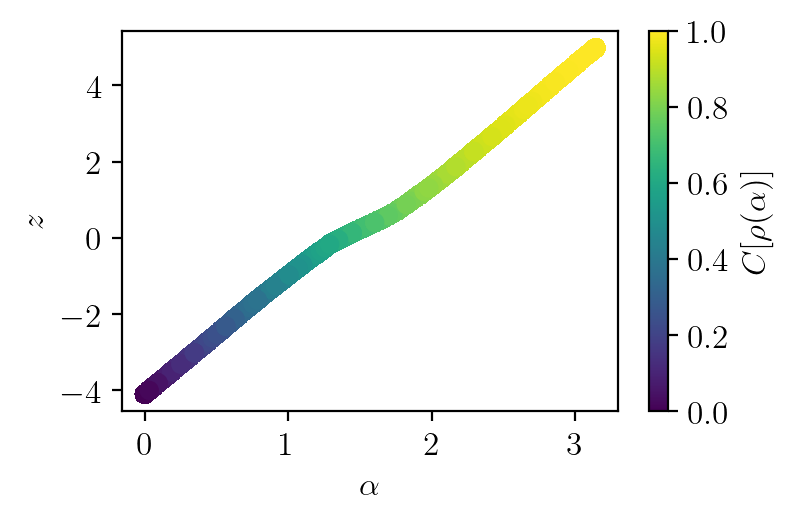

In [6]:
plot_scatter(y_test_noiseless,z_mean_noiseless[:,0],concurrence_noiseless_arr,"$\\alpha$","$z$","$C[\\rho(\\alpha)]$",1)

# Noisy Dataset  $0.75\beta$

Load Dataset

In [7]:
rho_arr_noisy = np.load('unitary_4x4_101_1000.npy', mmap_mode="r")
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(rho_arr_noisy, alpha_arr, random_state=42)
concurrence_noisy_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test_noisy])

Load trained VAE and define Hyperparameters:

In [8]:
batch_size = 64
beta = 0.75
learning_rate = 0.0001
lat_dim = 1
hidden_act = "tanh"
final_act = "linear"

encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)
encoder.load_weights("encoder_noise_075beta.h5")
decoder.load_weights("decoder_noise_075beta.h5")

vae_noisy = VAE(encoder, decoder, beta)
vae_noisy.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae_noisy.fit(X_test_noisy, epochs=1, batch_size=64, verbose=1) 

z_mean_noisy, z_log_var_noisy, z_noisy = vae_noisy.encoder.predict(X_test_noisy)

790/790 [==============================] - 0s 547us/step


Investigate Latent Space

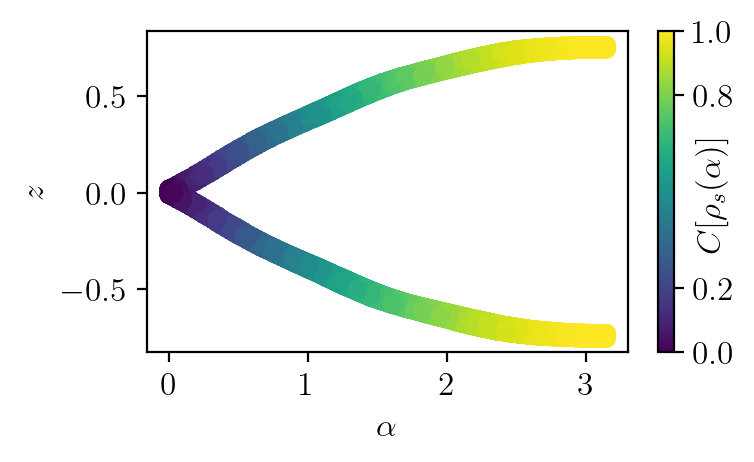

In [9]:
fig,ax = plt.subplots()
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$z$")
p = ax.scatter(y_test_noisy,z_mean_noisy[:,0],c=concurrence_noisy_arr)
cbar = fig.colorbar(p,shrink=1,pad=0.05)
fig.text(0.89, 0.47,"$C[\\rho_s(\\alpha)]$",rotation=90)
cbar.set_ticks([0.0,0.2,0.8,1.0])
plt.tight_layout()
# plt.savefig("/home/felix/Downloads/fig_rhos.pdf")

# 3D Latent Space

790/790 [==============================] - 0s 554us/step


/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_37896/2164464994.py:45: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


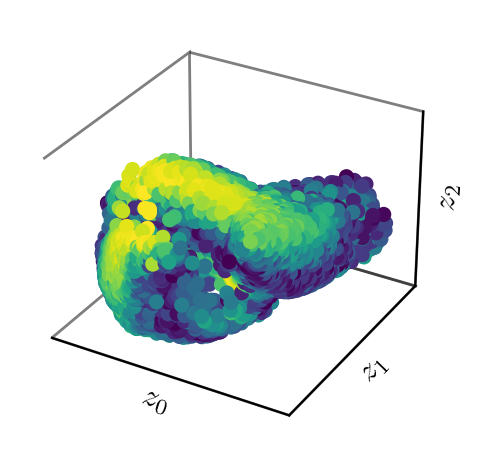

In [10]:
batch_size = 64
beta = 0.0
learning_rate = 0.0001
lat_dim = 3
hidden_act = "tanh"
final_act = "linear"

encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("/home/felix/Downloads/vae/encoder_3lv_00beta_ramp.h5")
decoder.load_weights("/home/felix/Downloads/vae/decoder_3lv_00beta_ramp.h5")

vae_3d = VAE(encoder, decoder, beta)
vae_3d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae_3d.fit(X_test_noisy, epochs=1, batch_size=64, verbose=1) 

z_mean_3d, _, _ = vae_3d.encoder.predict(X_test_noisy)

tsne = TSNE()
X_embedded = tsne.fit_transform(z_mean_3d[:5000])


fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(projection='3d')

ax.scatter(z_mean_3d[:,0], z_mean_3d[:,2],z_mean_3d[:,1], c=concurrence_noisy_arr, alpha=1)

ax.set_xlabel("$z_0$",labelpad=-15)
ax.set_ylabel("$z_1$",labelpad=-15,)
ax.set_zlabel("$z_2$",labelpad=-15)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])
                
plt.tight_layout()

# Figures 

In [11]:
lat_arr = np.arange(1,9)
n_exp = 9

recon_loss_noiseless = np.zeros((len(lat_arr),n_exp, 1))
recon_loss_noise = np.zeros((len(lat_arr),n_exp, 1))
recon_loss_noise_075 = np.zeros((len(lat_arr),n_exp, 1))


for cnt_1, inx in enumerate(lat_arr):
    for cnt_2 in range(n_exp):
        read_dictionary = np.load('no_0beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_noiseless[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"][-1]
        
        read_dictionary = np.load('noise_0beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_noise[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"][-1]
        
        read_dictionary = np.load('noise_075beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_noise_075[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"][-1]

av_recon_loss_arr_noiseless = np.average(recon_loss_noiseless,axis=1)
std_recon_loss_arr_noiseless = np.std(recon_loss_noiseless,axis=1)

av_recon_loss_arr_noise = np.average(recon_loss_noise,axis=1)
std_recon_loss_arr_noise = np.std(recon_loss_noise,axis=1)

av_recon_loss_arr_noise_075 = np.average(recon_loss_noise_075,axis=1)
std_recon_loss_arr_noise_075 = np.std(recon_loss_noise_075,axis=1)

In [12]:
selected_alpha_noiseless, selected_conc_noiseless, selected_z_noiseless, pred_conc_noiseless, pred_alpha_noiseless, fitobj_conc_noiseless, fitobj_alpha_noiseless = gen_plot_data(rho_arr_noiseless, vae_noiseless, scan_arr)  
selected_alpha_noisy, selected_conc_noisy, selected_z_noisy, pred_conc_noisy, pred_alpha_noisy, fitobj_conc_noisy, fitobj_alpha_noisy = gen_plot_data(rho_arr_noisy, vae_noisy, scan_arr)  
selected_alpha_generalized, selected_conc_generalized, selected_z_generalized, pred_conc_generalized, pred_alpha_generalized, fitobj_conc_generalized, fitobj_alpha_generalized = gen_plot_data(rho_arr_noiseless, vae_noisy, scan_arr)      

7/7 [==============================] - 0s 763us/step


In [13]:
def add_subplot_axes(ax,rect,facecolor='w'): 
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    
    yy_labelsize = subax.get_yticklabels()      
    
    
    subax.yaxis.offsetText.set_fontsize(y_labelsize)
    
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    print(y_labelsize)
    return subax

5.196152422706632


Text(0.035, 0.95, '$\\rho(\\alpha), \\beta=0$')

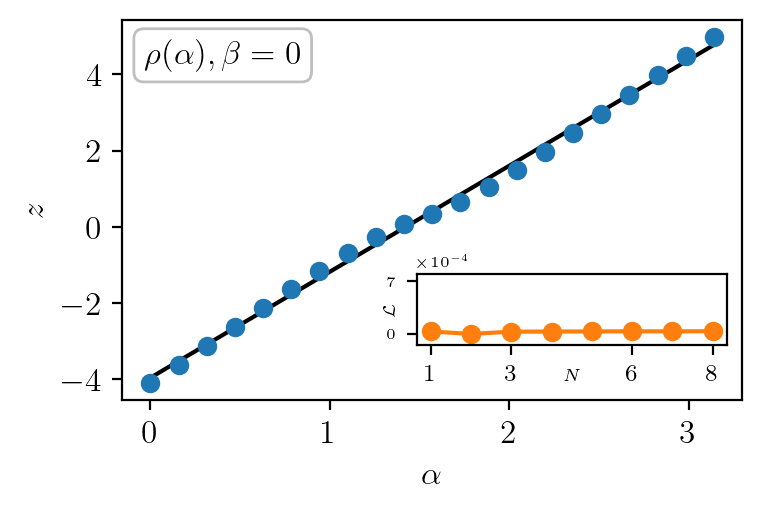

In [14]:
fig, ax = plt.subplots()

ax.errorbar(selected_alpha_noiseless[:,0],np.mean(selected_z_noiseless,axis=1),np.std(selected_z_noiseless,axis=1),ls='',marker="o",capsize=0, capthick=1, ecolor='black',
              label="$\\rho(\\alpha)\ \\beta=0.00$")
ax.plot(selected_alpha_noiseless[:,0], np.mean(linear_fit(selected_alpha_noiseless.flatten(), selected_z_noiseless.flatten())[0] ,axis=1),c="black")

rect = [0.475,0.145,0.5,0.5/(0.4/0.15)]
ax1 = add_subplot_axes(ax,rect)

ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$z$")


ax1.errorbar(lat_arr, av_recon_loss_arr_noiseless.flatten(),std_recon_loss_arr_noiseless.flatten(),ls='-',marker="o",capsize=0, capthick=1, ecolor='black',color="C1")

ax1.set_xlabel("$N$",labelpad=-6)
ax1.set_ylabel("$\\mathcal{L}$",labelpad=-4)
ax1.xaxis.label.set_fontsize(1.3*4.6475800154489)
ax1.yaxis.label.set_fontsize(1.3*4.6475800154489)

ax1.set_ylim(-0.00015,0.0008)
ax1.set_yticks([0.00000,0.0007])
ax1.set_xticks([1,3,6,8])


ax1.ticklabel_format(axis="y", style="sci",scilimits=(0,0))

textstr = "$\\rho(\\alpha), \\beta=0$"
props = dict(boxstyle='round', facecolor='white', alpha=0.25)
ax.text(0.035, 0.95, textstr, transform=ax.transAxes, 
        verticalalignment='top', bbox=props)
# plt.savefig("/home/felix/Downloads/fig_exp1_new.pdf",bbox_inches="tight",pad_inches=0.1)

5.196152422706632


Text(0.035, 0.95, '$\\rho_s(\\alpha), \\beta=0.75$')

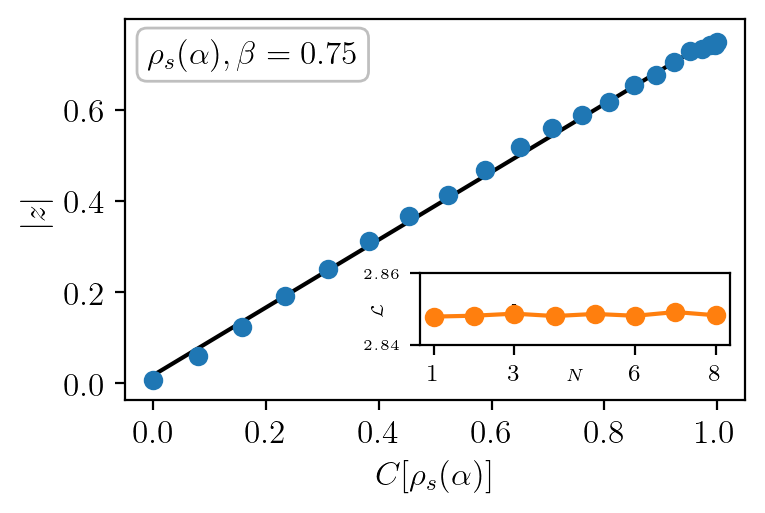

In [15]:
fig, ax = plt.subplots()

ax.errorbar(selected_conc_noisy[:,0],np.mean(np.abs(selected_z_noisy),axis=1),np.std(np.abs(selected_z_noisy),axis=1),ls='',marker="o",capsize=0, capthick=1, ecolor='black',
              label="$\\rho_s(\\alpha)\ \\beta=0.75$")
ax.plot(selected_conc_noisy[:,0], np.mean(linear_fit(selected_conc_noisy.flatten(), np.abs(selected_z_noisy).flatten())[0] ,axis=1),c="black")

rect = [0.475,0.145,0.5,0.5/(0.4/0.15)]
ax1 = add_subplot_axes(ax,rect)

ax.set_xlabel("$C[\\rho_s(\\alpha)]$")
ax.set_ylabel("$|z|$")


ax1.errorbar(lat_arr, av_recon_loss_arr_noise_075.flatten(),std_recon_loss_arr_noise_075.flatten(),ls='-',marker="o",capsize=0, capthick=1, ecolor='black',color="C1")

ax1.set_xlabel("$N$",labelpad=-6)
ax1.set_ylabel("$\\mathcal{L}$",labelpad=-8)
ax1.xaxis.label.set_fontsize(1.3*4.6475800154489)
ax1.yaxis.label.set_fontsize(1.3*4.6475800154489)

ax1.set_xticks([1,3,6,8])

ax1.set_ylabel("$\\mathcal{L}$")
ax1.set_xlabel("$N$")
ax1.set_yticks([2.84,2.86])
ax1.set_xticks([1,3,6,8])

textstr = "$\\rho_s(\\alpha), \\beta=0.75$"
props = dict(boxstyle='round', facecolor='white', alpha=0.25)
ax.text(0.035, 0.95, textstr, transform=ax.transAxes, 
        verticalalignment='top', bbox=props)
# plt.savefig("/home/felix/Downloads/fig_exp4_new.pdf",bbox_inches="tight",pad_inches=0.1)

3.6791303320214137


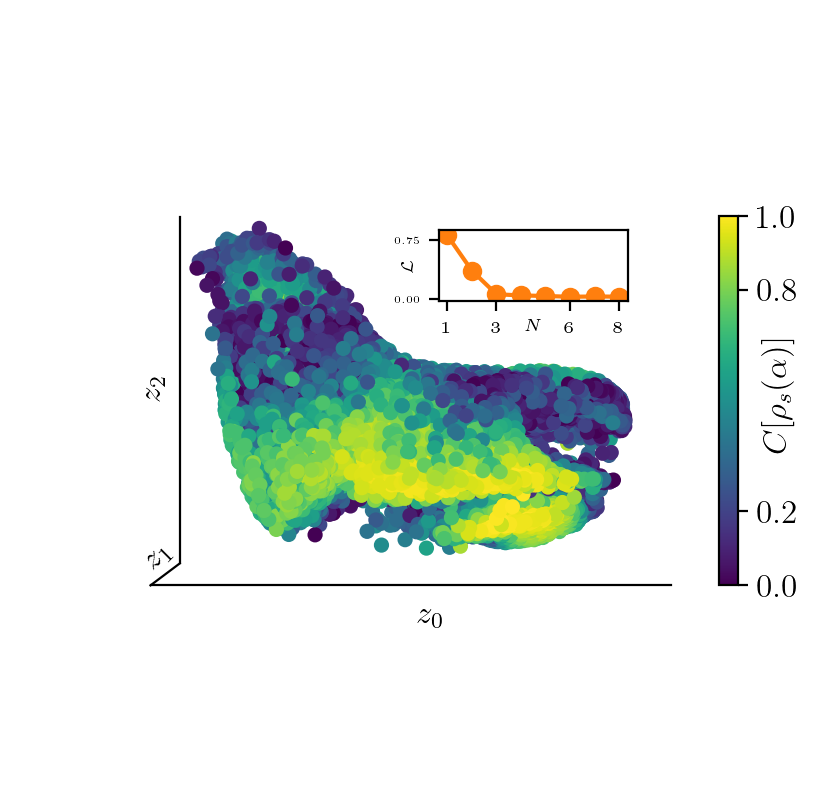

In [16]:
fig = plt.figure(figsize=(2*fig_size_dim, 2*fig_size_dim/golden_ratio))
ax = fig.add_subplot(projection='3d') 
p = ax.scatter(z_mean_3d[:,0], z_mean_3d[:,1],z_mean_3d[:,2],alpha=1, c=concurrence_noisy_arr,clip_on=False)
cbar = fig.colorbar(p,shrink=0.485,pad=-0.05)
fig.text(0.81, 0.45,"$C[\\rho_s(\\alpha)]$",rotation=90)

cbar.set_ticks([0.0,0.2,0.8,1.0])

ax.grid(False)
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.zaxis.set_ticks([])
ax.view_init(0, 90)
fig.text(0.52+0.075, 0.27,"$z_0$")
fig.text(0.345+0.075, 0.325,"$z_1$",rotation=45)
fig.text(0.345+0.075, 0.5,"$z_2$",rotation=90)

rect = [0.55,0.63,0.248,0.094]
ax1 = add_subplot_axes(ax,rect)
ax1.errorbar(lat_arr, av_recon_loss_arr_noise.flatten(),std_recon_loss_arr_noise.flatten(),ls='-',marker="o",capsize=0, capthick=1, ecolor='black',label="$\\rho_s(\\alpha)\  \\beta=0.00$",color="C1")

ax1.set_xlabel("$N$",labelpad=-6)
ax1.set_ylabel("$\\mathcal{L}$",labelpad=-8)
ax1.set_yticks([0,0.75])
ax1.set_xticks([1,3,6,8])
ax1.xaxis.label.set_fontsize(1.3*4.6475800154489)
ax1.yaxis.label.set_fontsize(1.3*4.6475800154489)
textstr = "$\\rho_s(\\alpha), \\beta=0$"


# plt.savefig("/home/felix/Downloads/fig_exp2_new.pdf",bbox_inches="tight",pad_inches=0.1)


In [17]:
slope, intercept, r_value, p_value, std_err = linregress(selected_alpha_noiseless[:,0],np.mean(selected_z_noiseless,axis=1))
np.round(r_value**2,3)

0.997

In [18]:
slope, intercept, r_value, p_value, std_err = linregress(selected_conc_noisy[:,0],np.mean(np.abs(selected_z_noisy),axis=1))
np.round(r_value**2,3)

0.998

In [19]:
slope, intercept, r_value, p_value, std_err = linregress(selected_conc_noisy[:,0],np.mean(np.concatenate((np.abs(pred_conc_noisy),np.abs(pred_conc_generalized)),axis=1),axis=1))
np.round(r_value**2,3)

0.998

# Generalization

4/4 [==============================] - 0s 1ms/step
0.9989304968480093
0.9992927180787248
0.9992927180787248
4/4 [==============================] - 0s 1ms/step


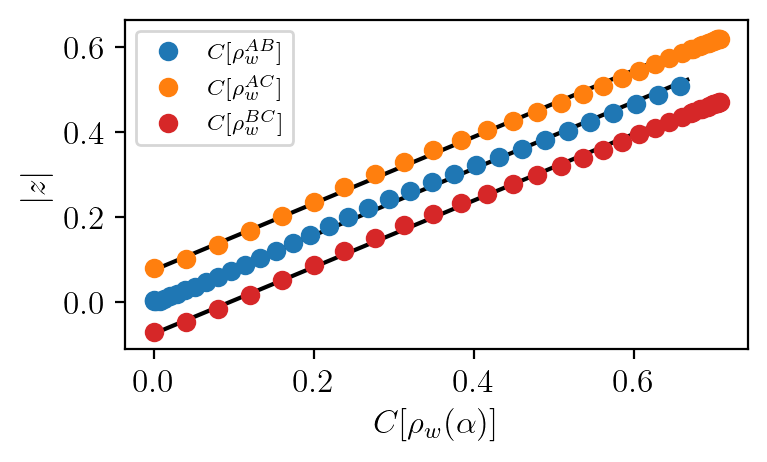

In [20]:
test_01 = np.load("test_arr_01.npy")
test_02 = np.load("test_arr_02.npy")
test_12 = np.load("test_arr_12.npy")

test_conc_01 = np.array([qt.concurrence(qt.Qobj(dm,dims=[[2,2],[2,2]])) for dm in np.array(test_01)])
test_conc_02 = np.array([qt.concurrence(qt.Qobj(dm,dims=[[2,2],[2,2]])) for dm in np.array(test_02)])
test_conc_12 = np.array([qt.concurrence(qt.Qobj(dm,dims=[[2,2],[2,2]])) for dm in np.array(test_12)])

max_angle = 2*np.arccos(1/np.sqrt(3)) 
scan_arr = np.linspace(0,max_angle,101)

fit_x_01 = test_conc_01.flatten()
fit_y_01 = -vae_noisy.encoder.predict(np.reshape(np.array(test_01),(101,16)))[0].flatten()
fit_obj_01 = np.polyfit(fit_x_01, fit_y_01, 1)
fit_pred_01 = np.poly1d(fit_obj_01)
fitted_y_01 = fit_pred_01(fit_x_01)

fit_x_02 = test_conc_02.flatten()
fit_y_02 = -vae_noisy.encoder.predict(np.reshape(np.array(test_02),(101,16)))[0].flatten()
fit_obj_02 = np.polyfit(fit_x_02, fit_y_02, 1)
fit_pred_02 = np.poly1d(fit_obj_02)
fitted_y_02 = fit_pred_01(fit_x_02)

fit_x_12 = test_conc_12.flatten()
fit_y_12 = -vae_noisy.encoder.predict(np.reshape(np.array(test_12),(101,16)))[0].flatten()
fit_obj_12 = np.polyfit(fit_x_12, fit_y_12, 1)
fit_pred_12 = np.poly1d(fit_obj_12)
fitted_y_12 = fit_pred_01(fit_x_12)

slope, intercept, r_value, p_value, std_err = linregress(fit_x_01, fit_y_01)
print(r_value**2)

slope, intercept, r_value, p_value, std_err = linregress(fit_x_02, fit_y_02)
print(r_value**2)

slope, intercept, r_value, p_value, std_err = linregress(fit_x_12, fit_y_12)
print(r_value**2)

fig, axs = plt.subplots()


axs.plot(test_conc_01, fitted_y_01 ,c="black")
axs.plot(test_conc_02, fitted_y_02+0.075 ,c="black")
axs.plot(test_conc_12, fitted_y_12-0.075 ,c="black")

axs.plot(test_conc_01[::3],np.abs(vae_noisy.encoder.predict(np.reshape(np.array(test_01),(101,16)))[0].flatten()[::3]),"o",
        label = "$C[\\rho^{AB}_w]$", c="C0")
axs.plot(test_conc_02[::3],np.abs(vae_noisy.encoder.predict(np.reshape(np.array(test_02),(101,16)))[0].flatten()[::3])+0.075,"o",
       label = "$C[\\rho^{AC}_w]$" , c="C1")
axs.plot(test_conc_12[::3],np.abs(vae_noisy.encoder.predict(np.reshape(np.array(test_12),(101,16)))[0].flatten()[::3])-0.075,"o",
        label = "$C[\\rho^{BC}_w]$", c="C3")

axs.set_xlabel("$C[\\rho_w(\\alpha)]$")
axs.set_ylabel("$|z|$")
axs.legend(fontsize="8")
plt.tight_layout()
# plt.savefig("/home/felix/Downloads/fig_exp6_final.pdf")

In [21]:
def get_dm():
    state = Statevector.from_int(0, 2**2)
    return DensityMatrix(state)

def get_random_u(n):
    z = np.random.randn(n,n)/np.sqrt(2.0)
    q,r = np.linalg.qr(z)
    d = np.diagonal(r)
    ph = d/np.absolute(d)
    q = np.multiply(q,ph,q)
    return q

def apply_u(dm, U):
    return  U * dm * U.dag() 



def gen_data_rand():
    cnt = 0 
    data_arr = np.zeros((210,16))
    conc_arr = np.zeros((210))
    
    for c_arr in selected_conc_noisy:
        for c in c_arr:
            Found = False
            while not Found:
                trial_state = apply_u(qt.Qobj(get_dm().data,dims=[[2,2],[2,2]]), qt.Qobj(get_random_u(4),dims=[[2,2],[2,2]]))
                if np.abs(np.array(trial_state).imag).sum() == 0 and np.isclose(qt.concurrence(trial_state),c,atol=2e-2):
                    data_arr[cnt] = np.array(trial_state).real.flatten()
                    conc_arr[cnt] = qt.concurrence(trial_state)
                    
                    cnt += 1 
                    Found = True
                    print(cnt)
            
    return data_arr, conc_arr

rand_data_arr, rand_conc_arr = gen_data_rand()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210


In [22]:
random_unitary_arr = rand_data_arr
z_mean_ru, _, _ = vae_noisy.encoder.predict(random_unitary_arr)
concur_arr_ru = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in random_unitary_arr])
pred_conc_ru = linear_fit(np.abs(z_mean_ru[:,0]),concur_arr_ru)[0]
z_mean_ru = np.reshape(z_mean_ru,(21,10))    
concur_arr_ru = np.reshape(concur_arr_ru,(21,10))
pred_conc_ru = np.reshape(pred_conc_ru,(21,10))

7/7 [==============================] - 0s 1ms/step


In [23]:
gamma = np.load('/home/felix/Downloads/gamma_new.npy', mmap_mode="r")[:76]
rho_gamma = np.load('/home/felix/Downloads/rho_gamma_noiseless.npy', mmap_mode="r")[:76]
conc_gamma_arr = np.array([qt.concurrence(qt.Qobj(np.reshape(dm,(4,4)),dims=[[2,2],[2,2]])) for dm in rho_gamma])

gamma_10 = np.repeat(gamma,10)
rho_gamma_10 = np.repeat(rho_gamma,10,axis=0)
conc_gamma_arr_10 = np.repeat(conc_gamma_arr,10)

z_mean_gamma, _, _ = vae_noisy.encoder.predict(rho_gamma)
z_mean_gamma_10, _, _ = vae_noisy.encoder.predict(rho_gamma_10)

gamma_10 = np.reshape(gamma_10,(76,10))
z_mean_gamma_10 = np.reshape(z_mean_gamma_10,(76,10))
conc_gamma_arr_10 = np.reshape(conc_gamma_arr_10,(76,10))


24/24 [==============================] - 0s 742us/step


In [24]:
def linear_fit(x, y):
    arr_len = int(len(x)/10)
    fit_obj = np.polyfit(x, y, 1)
    fit_pred = np.poly1d(fit_obj)
    return np.reshape(fit_pred(x), (arr_len, 10)), fit_pred

gamma_positive_conc_inx = conc_gamma_arr>0
x_fit_gamma = z_mean_gamma.flatten()[gamma_positive_conc_inx]
y_fit_gamma = conc_gamma_arr[gamma_positive_conc_inx]

fit_obj = np.polyfit(x_fit_gamma, y_fit_gamma, 1)
fit_pred = np.poly1d(fit_obj)

x_gamma = np.reshape(gamma_10,(76,10))
y_gamma = np.reshape(fit_pred(z_mean_gamma_10.flatten()),(76,10))

In [25]:
slope, intercept, r_value, p_value, std_err = linregress(gamma, z_mean_gamma.flatten())
print(slope*2.055)
slope, intercept, r_value, p_value, std_err = linregress(x_gamma.flatten(), y_gamma.flatten())
print(slope)

-1.5709048593086228
-1.5830638546061218


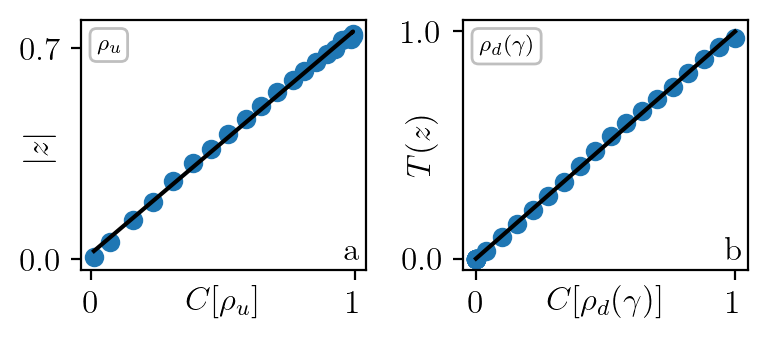

In [26]:
fig,ax = plt.subplots(1,2, figsize        = (fig_size_dim, 0.75*fig_size_dim/golden_ratio))

ax[0].errorbar(np.mean(concur_arr_ru,axis=1),np.mean(np.abs(z_mean_ru),axis=1),np.std(np.abs(z_mean_ru),axis=1),ls='',marker="o",capsize=0, capthick=1, ecolor='black',
              label="$\\rho_s$",zorder=-1)
ax[0].plot(np.mean(concur_arr_ru,axis=1), np.mean(linear_fit( concur_arr_ru.flatten(),np.abs(z_mean_ru).flatten())[0] ,axis=1),c="black")



ax[1].errorbar(np.mean(conc_gamma_arr_10,axis=1)[::3],np.maximum(np.mean(y_gamma,axis=1)[::3],0),np.maximum(np.std(y_gamma,axis=1)[::3],0),ls='',marker="o",capsize=0, capthick=1, ecolor='black',
              label="$\\rho_d$",zorder=-1)
ax[1].plot(np.mean(conc_gamma_arr_10,axis=1), np.mean(linear_fit(conc_gamma_arr_10.flatten(),np.maximum(y_gamma[::1],0).flatten())[0] ,axis=1),c="black")

ax[0].set_ylabel("$|z|$",labelpad=-13)
ax[1].set_ylabel("$T(z)$",labelpad=-13)

ax[0].set_yticks([0,0.7])
ax[1].set_yticks([0.0,1.0])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[0].set_xlabel("$C[\\rho_u]$",labelpad=-12)
ax[1].set_xlabel("$C[\\rho_d(\\gamma)]$",labelpad=-12)

fig.text(0.45, 0.28, "a", va='center')
fig.text(0.925, 0.28, "b", va='center')


textstr = "$\\rho_u$"
props = dict(boxstyle='round', facecolor='white', alpha=0.25)
ax[0].text(0.055, 0.94, textstr, transform=ax[0].transAxes, 
        verticalalignment='top', bbox=props,fontsize=8)

textstr = "$\\rho_d(\\gamma)$"
props = dict(boxstyle='round', facecolor='white', alpha=0.25)
ax[1].text(0.055, 0.94, textstr, transform=ax[1].transAxes, 
        verticalalignment='top', bbox=props,fontsize=8)

plt.tight_layout()

# plt.savefig("/home/felix/Downloads/fig_exp5_new.pdf")

In [27]:
def scale_dataset(dataset):
    min_value = np.min(dataset)
    max_value = np.max(dataset)
    min_range = -0.5
    max_range = 1

    scaled_dataset = (dataset - min_value) / (max_value - min_value) * (max_range - min_range) + min_range
    return scaled_dataset

scaled_data = scale_dataset(z_mean_gamma)

In [28]:
def c_test(rho):
    sysy = qt.tensor(qt.sigmay(), qt.sigmay())
    rho_tilde = (rho * sysy) * (rho.conj() * sysy)
    evals = rho_tilde.eigenenergies()
    evals = abs(np.sort(np.real(evals)))
    lsum = np.sqrt(evals[3]) - np.sqrt(evals[2]) - np.sqrt(evals[1]) - np.sqrt(evals[0])

    return lsum

test_c = np.array([c_test(qt.Qobj(np.reshape(dm,(4,4)),dims=[[2,2],[2,2]])) for dm in rho_gamma])

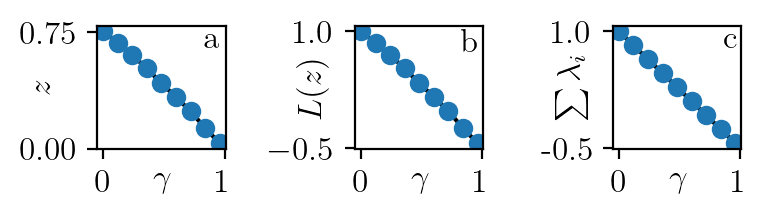

In [29]:
fig,ax = plt.subplots(1,3, figsize        = (fig_size_dim, (0.75*2/3)*fig_size_dim/golden_ratio))

ax[0].plot(gamma[::9],z_mean_gamma[::9] ,"-o", c='black', mfc='C0', mec='C0',label="L(z)")


ax[1].plot(gamma[::9],scaled_data[::9] ,"-o", c='black', mfc='C0', mec='C0',label="L(z)")


ax[2].plot(gamma[::9],test_c[::9] ,"-o", c='black', mfc='C0', mec='C0',label="L(z)")

ax[0].set_ylabel("$z$",labelpad=-13)
ax[1].set_ylabel("$L(z)$",labelpad=-22)
ax[2].set_ylabel("$\\sum \\lambda_i$",labelpad=-17)

ax[0].set_yticks([0.0,0.75])
ax[1].set_yticks([-0.5,1.0])
ax[2].set_yticks([-0.5,1.0])
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[0].set_xlabel("$\\gamma$",labelpad=-12)
ax[1].set_xlabel("$\\gamma$",labelpad=-12)
ax[2].set_xlabel("$\\gamma$",labelpad=-12)

fig.text(0.275, 0.785, "a", va='center')
fig.text(0.595, 0.77, "b", va='center')
fig.text(0.925, 0.785, "c", va='center')

textstr = "$\\rho_u$"
props = dict(boxstyle='round', facecolor='white', alpha=0.25)

textstr = "$\\rho_d(\\gamma)$"
props = dict(boxstyle='round', facecolor='white', alpha=0.25)

plt.tight_layout()

# plt.savefig("/home/felix/Downloads/fig_depol_appx.pdf")

In [30]:
slope, intercept, r_value, p_value, std_err = linregress(conc_gamma_arr[::7],np.maximum(np.mean(y_gamma,axis=1)[::7],0))
r_value**2

0.9989813764877113

Text(0, 0.5, 'PPT')

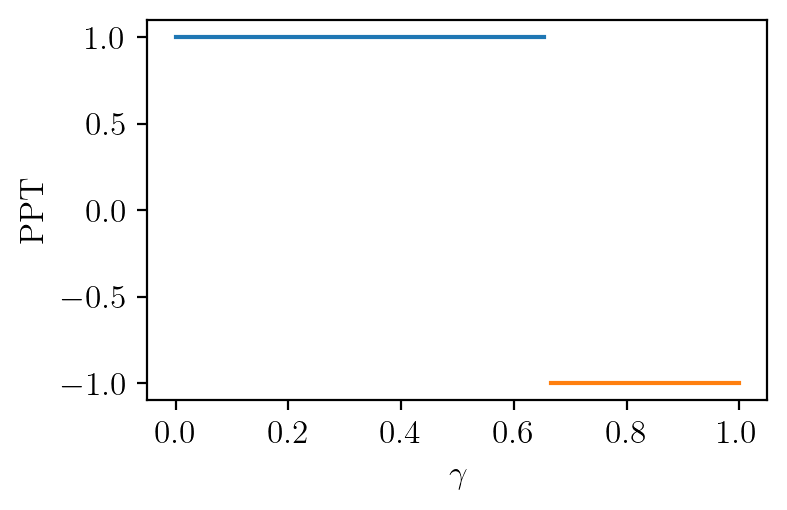

In [31]:
partial_transpose_arr = np.array([qt.partial_transpose(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]]),[1,0]).eigenenergies() for dm in rho_gamma])
positive_inx = np.array([np.any(t < 0) for t in partial_transpose_arr])
negative_inx = np.array([np.any(t < 0) for t in partial_transpose_arr])

plt.plot(gamma[positive_inx],np.ones(len(gamma[positive_inx])),)
plt.plot(gamma[~positive_inx],-1*np.ones(len(gamma[~positive_inx])))
plt.xlabel("$\\gamma$")
plt.ylabel("PPT")

# Beta Scan

In [32]:
inx_dict = {"001":0.01,"01":0.1,"02":0.2,"03":0.3,
            "04":0.4,"05":0.5,"06":0.6,"07":0.7,
            "08":0.8,"09":0.9,"10":1.0,"11":1.1, "12":1.2}
beta_list = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]

In [33]:
def gen_two_largest_z(beta):

    beta_inx = str(beta).replace(".","")
    
    learning_rate = 0.0001
    lat_dim = 8
    hidden_act = "tanh"
    final_act = "linear"

    encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

    encoder.load_weights("grid_8/encoder_{}_grid_8.h5".format(beta_inx))
    decoder.load_weights("grid_8/decoder_{}_grid_8.h5".format(beta_inx))

    vae_beta = VAE(encoder, decoder, beta)
    vae_beta.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    history_dict = vae_beta.fit(X_test_noisy, epochs=1, batch_size=64, verbose=0) 
    z_mean_beta, z_log_var_beta, z_beta = vae_beta.encoder.predict(X_test_noisy)
        
    temp_arr = np.zeros(8)
    for i in range(8):
            temp_arr[i] = np.average(kl_loss(z_mean_beta[:,i], z_log_var_beta[:,i]))
    sort_inx = np.argsort(temp_arr)

    return z_mean_beta[:,sort_inx[-1]][::1], z_mean_beta[:,sort_inx[-2]][::1]

In [34]:
z_001_0, z_001_1 = gen_two_largest_z(0.01)
# plt.scatter(z_001_0, z_001_1,c=concurrence_noisy_arr[::1])

z_04_0, z_04_1 = gen_two_largest_z(0.4)
# plt.scatter(z_04_0, z_04_1,c=concurrence_noisy_arr[::1])

z_07_0, z_07_1 = gen_two_largest_z(0.7)
# plt.scatter(z_07_0, z_07_1,c=concurrence_noisy_arr[::1])

z_1_0, z_1_1 = gen_two_largest_z(1.0)
# plt.scatter(z_1_0, z_1_1,c=concurrence_noisy_arr[::1])

790/790 [==============================] - 0s 558us/step


790/790 [==============================] - 1s 654us/step


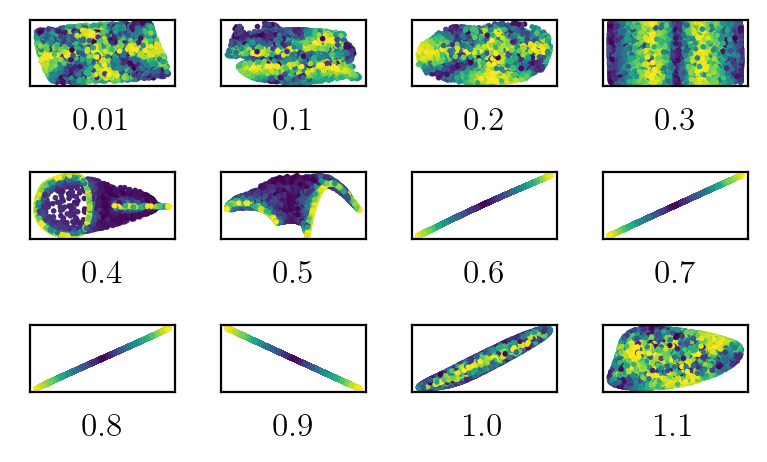

In [35]:
columns = 4
rows = 3
cnt = 0 
fig, ax_array = plt.subplots(rows, columns,squeeze=False)
for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.set_yticks([])
        axes.set_xticks([])
        x_scatter, y_scatter = gen_two_largest_z(list(inx_dict.values())[cnt])
        axes.scatter(x_scatter, y_scatter,c=concurrence_noisy_arr[::1],s=1)
        axes.set_xlabel("$"+str(list(inx_dict.values())[cnt])+"$")
        cnt += 1
plt.tight_layout()
plt.show()

In [36]:
recon_loss_arr = np.zeros(len(inx_dict))
kl_loss_arr = np.zeros(len(inx_dict))
full_kl_loss_arr = np.zeros((len(inx_dict),8))
full_kl_loss_arr_2 = np.zeros((len(inx_dict),8))

cnt = 0
for inx,beta in inx_dict.items():

    encoder, decoder = vae_mlp_4x4(8, hidden_act, final_act)

    encoder.load_weights("grid_8/encoder_{}_grid_8.h5".format(inx))
    decoder.load_weights("grid_8/decoder_{}_grid_8.h5".format(inx))

    vae_beta = VAE(encoder, decoder, beta)
    vae_beta.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    history_dict = vae_beta.fit(X_test_noisy, epochs=1, batch_size=64, verbose=0) 

    recon_loss_arr[cnt] = history_dict.history["reconstruction_loss"][0]
    kl_loss_arr[cnt] = history_dict.history["kl_loss"][0]
    
    z_mean_beta, z_log_var_beta, z_beta = vae_beta.encoder.predict(X_test_noisy)
    
    for i in range(8):
        full_kl_loss_arr[cnt][i] = np.average(kl_loss(z_mean_beta[:,i].astype(np.float64), z_log_var_beta[:,i].astype(np.float64)).astype(np.float64))
        full_kl_loss_arr_2[cnt][i] = np.average(kl_loss(z_mean_beta[:,i], z_log_var_beta[:,i]))

    cnt += 1 

790/790 [==============================] - 0s 551us/step


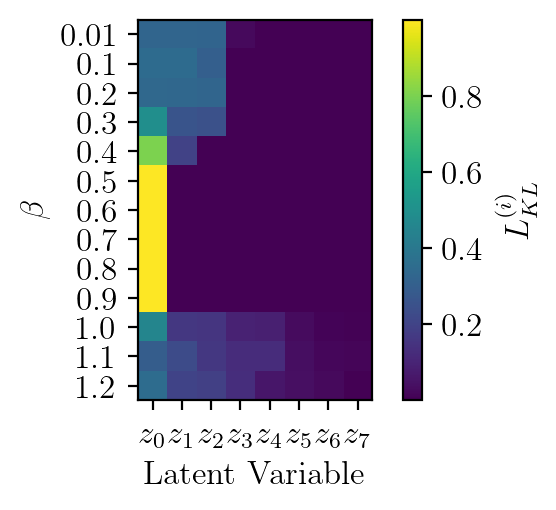

In [38]:
row_sums = np.sort(full_kl_loss_arr,axis=-1).sum(axis=1)
new_matrix = np.sort(full_kl_loss_arr,axis=-1) / row_sums[:, np.newaxis]

fig, ax = plt.subplots()
im = ax.imshow(np.flip(new_matrix,axis=1))
cbar = fig.colorbar(im)
cbar.set_label("$L_{KL}^{(i)}$")
plt.xticks(range(8),["$z_{}$".format(i) for i in range(8)])
plt.yticks(range(len(inx_dict)),beta_list)

plt.xlabel("Latent Variable")
plt.ylabel("$\\beta$")

plt.show()

Text(0.5, 0.565, '$\\mathcal{L}_{KL}^{(i)}$')

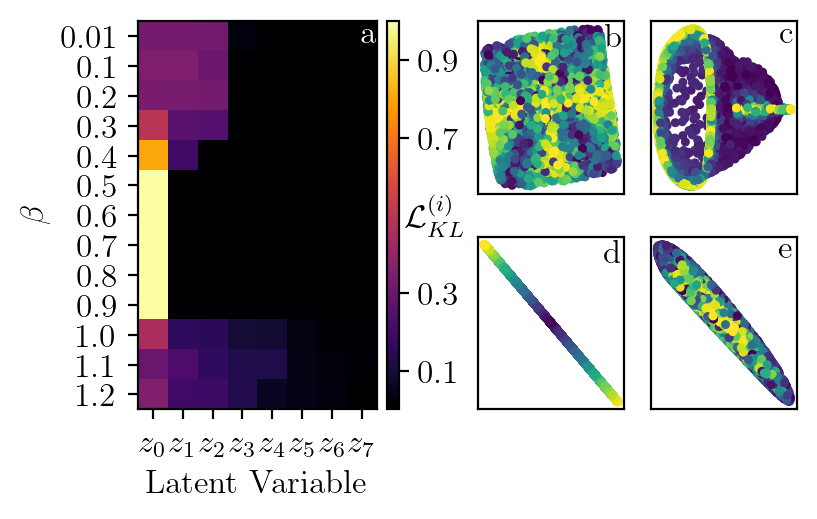

In [39]:
fig = plt.figure(constrained_layout=True)
axs = fig.subplot_mosaic([['Left', 'Top1','Top2'],['Left', 'Bottom1','Bottom2']],
                          gridspec_kw={'width_ratios':[2,0.8,0.8]})


im = axs['Left'].imshow(np.flip(new_matrix,axis=1),cmap="inferno")

divider = make_axes_locatable(axs['Left'])
cax = divider.append_axes('right', size='5%', pad=0.05)

cbar = plt.colorbar(im, cax=cax, orientation='vertical')
cbar.set_ticks([0.1,0.3,0.7,0.9])

axs['Left'].set_xticks(range(8),["$z_{}$".format(i) for i in range(8)])
axs['Left'].set_yticks(range(len(inx_dict)),["${}$".format(i) for i in beta_list])     

axs['Left'].set_xlabel("Latent Variable")
axs['Left'].set_ylabel("$\\beta$")

axs["Top1"].set_xticks([])
axs["Top1"].set_yticks([])
axs["Top2"].set_xticks([])
axs["Top2"].set_yticks([])
axs["Bottom1"].set_xticks([])
axs["Bottom1"].set_yticks([])
axs["Bottom2"].set_xticks([])
axs["Bottom2"].set_yticks([])

axs["Top1"].scatter(z_001_0,z_001_1, c= concurrence_noisy_arr,s=5)
axs["Top2"].scatter(z_04_0,z_04_1, c= concurrence_noisy_arr,s=5)
axs["Bottom1"].scatter(z_07_0,-z_07_1, c= concurrence_noisy_arr,s=5)
axs["Bottom2"].scatter(z_1_0,z_1_1, c= concurrence_noisy_arr,s=5)

fig.text(0.444, 0.94, "a",c="white")
fig.text(0.748, 0.932, "b")
fig.text(0.968, 0.94, "c")

fig.text(0.748, 0.495, "d")
fig.text(0.966, 0.505, "e")

fig.text(0.5,0.565,"$\\mathcal{L}_{KL}^{(i)}$")

# plt.savefig("/home/felix/Downloads/fig_exp3.pdf",bbox_inches="tight",pad_inches=0.1)

# Concurrence

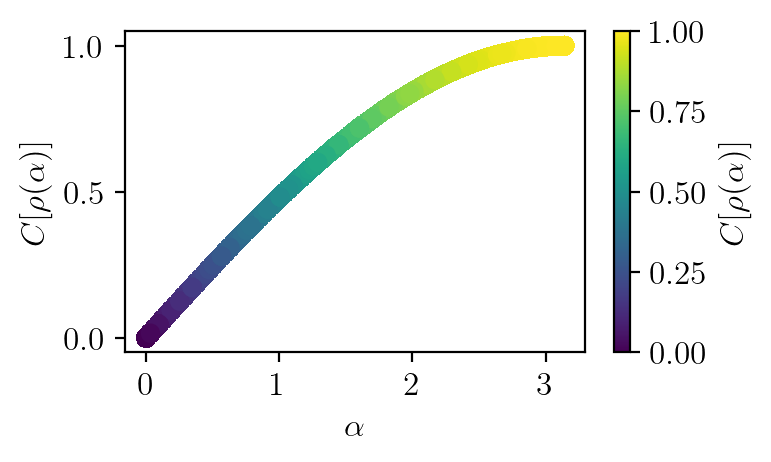

In [40]:
X_train, X_test, y_train, y_test = train_test_split(rho_arr_noiseless, alpha_arr, random_state=42)
conc_plot = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test])
# conc_plot = np.unique(conc_plot)
fig,ax = plt.subplots()
im = ax.scatter(y_test,conc_plot,c=conc_plot)
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$C[\\rho(\\alpha)]$")
cbar = fig.colorbar(im)
cbar.set_label("$C[\\rho(\\alpha)]$")
plt.tight_layout()
# plt.savefig("/home/felix/Downloads/fig10_concurrence.pdf")